# Encuesta Nacional de Nutrición y Salud (ENNyS2)

## Introducción

La Segunda Encuesta Nacional de Nutrición y Salud (ENNyS 2) es un relevamiento realizado en Argentina por la Secretaría de Gobierno de Salud de la Nación (hoy Ministerio de Salud) entre octubre de 2018 y febrero de 2019.

Su objetivo principal es describir la situación alimentaria y de salud de la población, recolectando información detallada sobre:

* Consumo de alimentos y bebidas (recordatorio de 24 horas, frecuencia y tipo de alimentos).

* Estado nutricional (mediciones antropométricas y datos de composición corporal).

* Enfermedades crónicas y factores de riesgo (hipertensión, diabetes, colesterol alto, etc.).

* Condiciones sociodemográficas y del hogar (cobertura de salud, nivel educativo, ingresos, etc.).

* Hábitos de vida (actividad física, lactancia, consumo de tabaco y alcohol, etc.).

La encuesta utiliza un diseño probabilístico, estratificado y multietápico, lo que permite que los resultados sean representativos a nivel nacional y por regiones.

### Se estructura en cuestionarios específicos por grupo etario:

* C1: Niños/as menores de 5 años.

* C2: Niños/as y adolescentes de 5 a 12 años.

* C3: Adolescentes de 13 a 17 años.

* C4: Adultos de 18 años o más.

En este trabajo utilizaremos la base principal de publicada en el portal de datos abiertos del Ministerio de Salud, junto con las bases complementarias de alimentos y nutrientes, para realizar un análisis que vincule alimentación, estado de salud y factores asociados.

## Objetivos de la notebook

Explorar la base principal de la ENNyS2 (encuesta) para:
- ubicar variables clave (edad, sexo, indicadores de salud, educación, región),
- revisar cobertura de datos en adultos (≥18),
- generar un subset mínimo limpio para notebooks posteriores.
- Mostramos capacidades de la base sin plantear hipótesis temáticas.

## Estructura de las columnas en ENNyS2

La base principal de ENNyS2 contiene aproximadamente 1830 columnas.
Estas variables se organizan en módulos y prefijos que indican el tipo de información, la población objetivo y, en algunos casos, la posición del miembro del hogar.

### Convenciones de nombres:

Cn_: Variables de cuestionarios específicos según grupo etario:

C1_: Niños/as menores de 5 años (respondido por adulto responsable).

C2_: Niños/as y adolescentes de 5 a 12 años.

C3_: Adolescentes de 13 a 17 años.

C4_: Adultos de 18 años o más.

T_Cn_: Variables totales o derivadas de un módulo.
Ejemplo: T_C4_ActFisTotal (total de minutos de actividad física en adultos).

I_Dx_Cn_: Indicadores por día dentro del módulo.
Ejemplo: I_D1_C4_Kcal (ingesta calórica del día 1 en adultos).

Mn_: Información de miembros del hogar (hasta 15 posibles).
Ejemplo: M1_Edad, M2_Sexo (edad y sexo del miembro 1 y 2).

## Decisión de trabajo para este análisis

En este proyecto nos vamos a centrar solo en la población adulta.

### Esto implica:

* Filtrar registros con Edadd >= 18.

* Trabajar exclusivamente con columnas que pertenecen al módulo adulto (C4_), evitando así unificación entre módulos y reduciendo valores faltantes.

* Esta estrategia simplifica el análisis y asegura que todas las variables provengan del mismo cuestionario, con comparabilidad directa.

---

## 1. Leer la base CSV

In [7]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA = Path("../data") # Previamente hay que descargar los datos manualmente y descomprimirlos en este directorio
FILE = DATA / "ENNyS2_encuesta.csv"

df = pd.read_csv(FILE, encoding="utf-8-sig", low_memory=False)

df.shape

(21358, 1830)

---

## 2. Unificamos las columnas SEXO

El sexo de la persona puede estar en cualquiera de las 4 columnas, según la encuenta que realizó.

In [2]:
# 1) elegimos las columnas que existan
cols_sexo = [c for c in ["C4_SEXO","C3_SEXO","C2_SEXO","C1_SEXO"] if c in df.columns]

# 2) tomamos solo esas columnas y convertimos vacíos/espacios a NA
tmp = df[cols_sexo].copy()
tmp = tmp.replace(r"^\s*$", pd.NA, regex=True)  # cualquier cadena vacía -> NA

# 3) completamos por filas con el primer no-NA disponible (backfill horizontal)
#    y nos quedamos con la primera columna resultante
df["SEXO"] = tmp.bfill(axis=1).iloc[:, 0]

# 4) chequeo rápido
print(df["SEXO"].value_counts(dropna=False).head(10))
print("NA en SEXO (%):", df["SEXO"].isna().mean()*100)

SEXO
Mujer    11070
Varón    10288
Name: count, dtype: int64
NA en SEXO (%): 0.0


## 3. Mapeo de columnas

In [ ]:
cols_map = {
    "edad": "Edadd",
    "sexo": "SEXO",
    "imc": "IMC",
    "cobertura_salud": "Cobertura_salud",
    "quintil_ingresos": "IngHog_UC_QUINT_imp",
    "hta": None,  # pendiente de identificar
    "diabetes": None,
    "colesterol_alto": None
}
cols_map


{'edad': 'Edadd',
 'sexo': 'SEXO',
 'imc': 'IMC',
 'cobertura_salud': 'Cobertura_salud',
 'quintil_ingresos': 'IngHog_UC_QUINT_imp',
 'hta': None,
 'diabetes': None,
 'colesterol_alto': None}

## 4. Filtrar adultos (≥18)

In [4]:
df_ad = df[pd.to_numeric(df[cols_map["edad"]], errors="coerce") >= 18].copy()
df_ad.shape


(13935, 1831)

## 5. Cobertura de datos

In [5]:
relevantes = ["Edadd", "SEXO", "IMC", "Cobertura_salud", "IngHog_UC_QUINT_imp"]

df_chk = df_ad[relevantes].copy()
df_chk = df_chk.replace(["", " ", "  ", "NA", "NaN", "ns/nc", "NS/NC"], pd.NA)

na_pct = (df_chk.isna().mean()*100).round(1)
na_pct.to_frame("%NA")


,%NA
Edadd,0.0
SEXO,0.0
IMC,0.6
Cobertura_salud,0.4
IngHog_UC_QUINT_imp,0.0


## 5. Estadísticas descriptivas

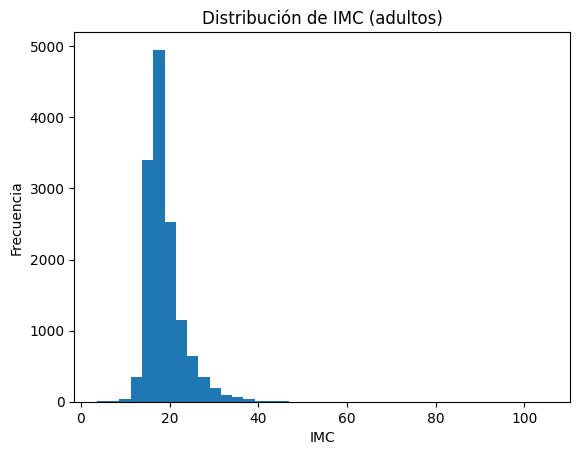

SEXO
Varón    7154
Mujer    6781
Name: count, dtype: int64


In [6]:
# Histograma IMC
df_ad[cols_map["imc"]] = pd.to_numeric(df_ad[cols_map["imc"]], errors="coerce")
df_ad[cols_map["imc"]].plot(kind="hist", bins=40)
plt.title("Distribución de IMC (adultos)")
plt.xlabel("IMC")
plt.ylabel("Frecuencia")
plt.show()

# Distribución por sexo
print(df_ad[cols_map["sexo"]].value_counts(dropna=False))
